In [150]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from datetime import datetime
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from sklearn import mixture
from sklearn.decomposition import PCA
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from xgboost import plot_importance

In [2]:
subs = pd.read_csv("subscribers.csv")

In [13]:
chan = pd.read_csv("channel_spend_graduate.csv")

# Data Preprocess

In [4]:
age = []
for i in subs['age']:
    if i >=110 or i <= 3:
        age.append(np.nan)
    else:
        age.append(i)

In [35]:
subs['age'] = age
subs1 = subs.copy()
###Delete columns meaningless/ without variation/ with more than 20% missing
subs1 = subs1.drop(["Unnamed: 0","num_weekly_services_utilized","num_ideal_streaming_services","payment_type","last_payment","next_payment","cancel_date","country","months_per_bill_period","monthly_price","language","trial_end_date","attribution_technical"],axis = 1)

In [36]:
date = list(subs1["account_creation_date"])
year = []
month = []
day = []
time = []
for i in date:
    year.append(int(i.split(" ")[0].split("-")[0]))
    month.append(int(i.split(" ")[0].split("-")[1]))
    day.append(int(datetime.strptime(i.split(" ")[0], "%Y-%m-%d").weekday()+1))
    time.append(int(i.split(" ")[1].split(":")[0]))
subs1['creation_year'] = year
subs1['creation_month'] = month
subs1['creation_day'] = day
subs1['creation_time'] = time
subs1 = subs1.drop(['account_creation_date'],axis = 1)

In [37]:
retention = list()
n = range(0,len(subs1['subid']))
for i in n:
    if subs1['current_sub_TF'][i] == True and subs1['payment_period'][i] > 0 and subs1['trial_completed'][i] == True:
        retention.append(True)
    else:
        retention.append(False)
subs1['retention'] = retention
subs1 = subs1.drop(['current_sub_TF'],axis = 1)

In [38]:
numerical = ['weekly_consumption_hour','age','discount_price','join_fee']
categorical = ['package_type','preferred_genre','intended_use','male_TF','attribution_survey','op_sys','plan_type','initial_credit_card_declined','num_trial_days','payment_period','trial_completed','creation_year','creation_month','creation_day','creation_time','retention']

In [39]:
subs1['subid'] = subs1['subid'].astype('object')
for i in numerical:
    subs1[i] = subs1[i].fillna(method = 'pad',axis = 0)
    subs1[i] = subs1[i].fillna(subs1[i].mean())
for i in categorical:
    subs1[i] = subs1[i].fillna(method = 'pad',axis = 0)
    #subs1[i] = subs1[i].astype('category')
subs1['age'] = subs1['age'].astype('int')

In [90]:
weekend = []
for i in subs1['creation_day']:
    if i == 5 or i == 6 or i == 7:
        weekend.append(1)
    else:
        weekend.append(0)
        
summer = []
for i in subs1['creation_month']:
    if i == 6 or i == 7 or i == 8:
        summer.append(1)
    else:
        summer.append(0)
        
worktime = []
for i in subs1['creation_time']:
    if i >= 8 and i <= 18:
        worktime.append(1)
    else:
        worktime.append(0)
        
subs1['weekend'] = weekend
subs1['summer'] = summer
subs1['worktime'] = worktime

In [89]:
sum(summer)

53805

In [14]:
chan1 = pd.get_dummies(chan,columns = ['date'])

In [16]:
columns = chan1.columns[2:10]

In [17]:
for i in columns:
    chan1[i] = chan1['spend_AED'].mul(chan1[i])
chan1 = chan1.drop(['spend_AED'],axis = 1)

In [171]:
chan2.columns

Index(['date_201907', 'date_201908', 'date_201909', 'date_201910',
       'date_201911', 'date_201912', 'date_202001', 'date_202002'],
      dtype='object')

In [18]:
chan2= chan1[list(chan1.columns)].groupby(['channel']).sum()

In [184]:
chan3 = chan2.eval('Total=date_201907+date_201908+date_201909+date_201910+date_201911+date_201912+date_202001+date_202002')

# Customer Segmentation

In [104]:
columns_cluster = ['subid','package_type','preferred_genre','intended_use','weekly_consumption_hour','age','male_TF','attribution_survey','op_sys','plan_type','creation_year','creation_month','creation_day','creation_time']

In [105]:
subs1_cluster = subs1[columns_cluster]

In [108]:
columns_dummies = ['package_type', 'preferred_genre', 'intended_use','male_TF', 'attribution_survey','op_sys', 'plan_type', 'creation_year','creation_month','creation_day','creation_time']

In [109]:
subs2_cluster = pd.get_dummies(subs1_cluster,columns = columns_dummies)

In [110]:
subs3_cluster = subs2_cluster.copy()
for c in ['weekly_consumption_hour','age']:
    subs3_cluster[c] = scale(np.array(subs2_cluster[c]).reshape(-1, 1))

C:\Users\xsc\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [68]:
gmm_3 = mixture.GaussianMixture(n_components=3, covariance_type='full')
gmm_3.fit(subs3_cluster[list(subs3_cluster.columns)[1:92]])
label_gmm_3 = gmm_3.predict(subs3_cluster[list(subs3_cluster.columns)[1:92]])

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [125]:
gmm_4 = mixture.GaussianMixture(n_components=4, covariance_type='full')
gmm_4.fit(subs3_cluster[list(subs3_cluster.columns)[1:92]])
label_gmm_4 = gmm_4.predict(subs3_cluster[list(subs3_cluster.columns)[1:92]])

In [119]:
kmeans_3 = KMeans(n_clusters=3)
kmeans_3.fit(subs3_cluster[list(subs3_cluster.columns)[1:92]])
label_kmeans_3 = kmeans_3.predict(subs3_cluster[list(subs3_cluster.columns)[1:92]])

In [126]:
kmeans_4 = KMeans(n_clusters=4)
kmeans_4.fit(subs3_cluster[list(subs3_cluster.columns)[1:92]])
label_kmeans_4 = kmeans_4.predict(subs3_cluster[list(subs3_cluster.columns)[1:92]])

In [117]:
SSE = []
for k in range(1,7):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(subs3_cluster[list(subs3_cluster.columns)[1:92]])
    SSE.append(kmeans.inertia_)

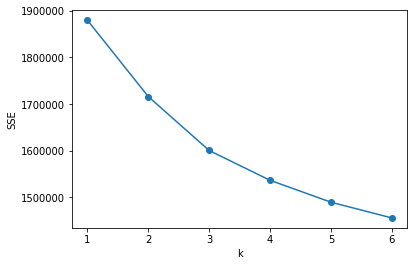

In [118]:
X = range(1,7)
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(X,SSE,'o-')
plt.show()

In [127]:
subs1['label_kmeans_3'] = label_kmeans_3
subs1['label_gmm_3'] = label_gmm_3
subs1['label_kmeans_4'] = label_kmeans_4
subs1['label_gmm_4'] = label_gmm_4

# Churn Model

In [139]:
subs1_churn = subs3_cluster.copy()
subs1_churn['discount_price'] = subs1['discount_price']
subs1_churn['initial_credit_card_declined'] = subs1['initial_credit_card_declined']
subs1_churn['join_fee'] = subs1['join_fee']
subs1_churn['num_trial_days'] = subs1['num_trial_days']
subs1_churn['retention'] = subs1['retention']
subs2_churn = pd.get_dummies(subs1_churn,columns = ['initial_credit_card_declined','num_trial_days'])
subs3_churn = subs2_churn.copy()
for c in ['discount_price','join_fee']:
    subs3_churn[c] = scale(np.array(subs2_churn[c]).reshape(-1, 1))

In [141]:
M1_train, M1_test = train_test_split(subs3_churn, random_state = 2020)
M1_predictors = [x for x in M1_train.columns if x not in ['subid','retention']]

In [142]:
xgbM1 = XGBClassifier()
xgbM1_1 = xgbM1.fit(M1_train[M1_predictors], M1_train['retention'],eval_metric='auc')
M1_test_predprob = xgbM1_1.predict_proba(M1_test[M1_predictors])[:,1] 

In [144]:
metrics.roc_auc_score(M1_test['retention'], M1_test_predprob) 

0.9013687315129479

In [145]:
confusion_matrix(M1_test['retention'],xgbM1_1.predict(M1_test[M1_predictors]))

array([[20856,  5652],
       [ 4740, 25659]], dtype=int64)

In [146]:
clf = LogisticRegression()
clf.fit(M1_train[M1_predictors], M1_train['retention'])
lg_test_predprob = clf.predict_proba(M1_test[M1_predictors])[:,1]

C:\Users\xsc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [147]:
metrics.roc_auc_score(M1_test['retention'], lg_test_predprob) 

0.8954722701375861

In [148]:
confusion_matrix(M1_test['retention'],clf.predict(M1_test[M1_predictors]))

array([[20993,  5515],
       [ 4866, 25533]], dtype=int64)

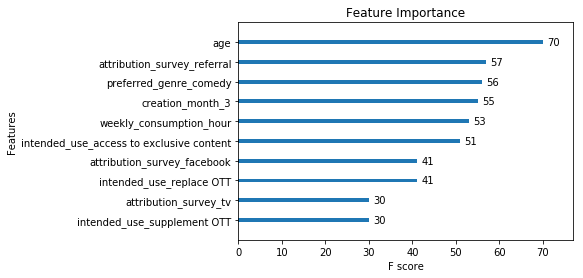

In [152]:
plot_importance(xgbM1_1, max_num_features = 10,title='Feature Importance', grid=False)
plt.show()

# Attribution and Allocation

In [164]:
att_tech = list(subs['attribution_technical'])
att_surv = list(subs1['attribution_survey'])

In [179]:
channels = []
for i in range(0,len(subs1['subid'])):
    if att_surv[i] == "facebook":
        channels.append("facebook")
    elif att_surv[i] == "youtube":
        channels.append("youtube")
    elif att_surv[i] == "search":
        channels.append("search") 
    else:
        if att_tech[i] == "facebook":
            channels.append("facebook")
        elif att_tech[i] == "youtube":
            channels.append("youtube")
        elif att_tech[i] == "search":
            channels.append("search") 
        elif att_tech[i] == "display":
            channels.append("display")
        elif att_tech[i] in ["bing","brand sem intent bing"]:
            channels.append("bing")
        else:
            channels.append("other")
subs1['channels'] = channels  

In [181]:
subs1['channels'].value_counts()

facebook    135048
other        65287
search       21228
youtube       3283
bing          2137
display        645
Name: channels, dtype: int64

In [185]:
CAC_avergae = [10800/2137,366/645,113500/135048,222500/21228,8730/3283]
chan3["CAC_avergae_subscribers"] = CAC_avergae

In [189]:
s_bing = 0
s_display = 0
s_facebook = 0
s_search = 0
s_youtube = 0
for i in range(0,len(subs1['subid'])):
    if subs1['retention'][i] == True:
        if subs1['channels'][i]=="bing":
            s_bing = s_bing+1
        elif subs1['channels'][i]=="display":
            s_display = s_display+1
        elif subs1['channels'][i]=="facebook":
            s_facebook = s_facebook+1
        elif subs1['channels'][i]=="search":
            s_search = s_search+1
        elif subs1['channels'][i]=="youtube":
            s_youtube = s_youtube+1

In [190]:
CAC_avergae_retention = [10800/s_bing,366/s_display,113500/s_facebook,222500/s_search,8730/s_youtube]
chan3["CAC_avergae_retention"] = CAC_avergae_retention

In [192]:
chan3.head()

,date_201907,date_201908,date_201909,date_201910,date_201911,date_201912,date_202001,date_202002,Total,CAC_avergae_subscribers,CAC_avergae_retention
channel,,,,,,,,,,,
bing,400,900,1000,1100,1300,300,2100,3700,10800,5.053814,10.682493
display,12,20,13,19,29,31,148,94,366,0.567442,1.042735
facebook,9000,13000,10500,17000,23000,16000,11000,14000,113500,0.840442,1.712768
search,13000,18500,19000,24000,25000,38000,41000,44000,222500,10.481440,16.213656
youtube,90,180,100,130,550,900,4360,2420,8730,2.659153,3.645094


In [194]:
subs1.to_csv('subs1.csv')